# Cthulhu News Draft Two

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

In [3]:
import json
import pickle
import random
import time
from collections import Counter
from datetime import datetime, timedelta, timezone
from difflib import SequenceMatcher
from pathlib import Path
from string import punctuation

import httpx
import matplotlib.pyplot as plt
import newspaper
import nltk
import numpy as np
import pandas as pd
import spacy
import spacy.cli
import spacy.displacy
import spacy.tokens
from dotenv import load_dotenv
from envparse import env
from loguru import logger
from logutil import init_loguru
from openai import OpenAI
from tenacity import retry, stop_after_attempt

In [10]:
from web import llm_cthulhu_new as llm
from web import llm_cthulhu_prompts as prompts

In [4]:
np.random.seed(42**3)
load_dotenv()

True

In [5]:
nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/nameless/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/nameless/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
# spacy_model_name = "en_core_web_sm"
spacy_model_name = "en_core_web_md"
# spacy_model_name = "en_core_web_lg"
# spacy_model_name = "en_core_web_trf"

try:
    spacy_nlp = spacy.load(spacy_model_name)
    logger.debug(f"loaded spacy model name='{spacy_model_name}' path='{spacy_nlp.path}'")
except Exception as e:
    logger.debug(str(e))
    spacy.cli.download(spacy_model_name)
    logger.debug(f"downloaded spacy model from web name='{spacy_model_name}'")
    spacy_nlp = spacy.load(spacy_model_name)
    logger.debug(f"loaded spacy model name='{spacy_model_name}' path='{spacy_nlp.path}'")

2024-12-03 14:56:00.818 | DEBUG    | __main__:<module>:8 - loaded spacy model name='en_core_web_md' path='/Users/nameless/dev/proj/cthulhu-news/.venv/lib/python3.12/site-packages/en_core_web_md/en_core_web_md-3.8.0'


2024-12-03T13:56:01.037Z __main__ DEBUG: this is a test log line


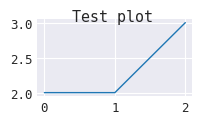

In [7]:
init_loguru()
logger.debug("this is a test log line")

# plt.style.use('ggplot')
# plt.style.use('dark_background')
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.size"] = 9

plt.figure(figsize=(2, 1))
plt.plot([0, 1, 2], [2, 2, 3])
plt.suptitle("Test plot")

np.set_printoptions(edgeitems=30, linewidth=10000)
pd.options.display.max_rows = 200
pd.options.display.max_columns = 80
pd.options.display.max_colwidth = 100

In [8]:
GNEWS_API_KEY = env.str("GNEWS_API_KEY")
print(GNEWS_API_KEY[-3:])
GNEWS_URL = "https://gnews.io/api/v4/search"

MONGO_USER = env.str("MONGO_INITDB_ROOT_USERNAME")
MONGO_PASSWORD = env.str("MONGO_INITDB_ROOT_PASSWORD")
MONGO_HOST = env.str("MONGO_HOST")
MONGO_PORT = env.int("MONGO_PORT")
MONGODB_URI = f"mongodb://{MONGO_USER}:{MONGO_PASSWORD}@{MONGO_HOST}:{MONGO_PORT}?retryWrites=true&w=majority"
print(MONGODB_URI[:11])

OPENAI_API_KEY = env.str("OPENAI_API_KEY")
print(OPENAI_API_KEY[-3:])

4df
mongodb://a
gsV


In [9]:
def default_json_converter(o):
    if isinstance(o, datetime):
        return o.isoformat()
    raise TypeError(f'Object of type {o.__class__.__name__} is not JSON serializable')

## Get news listings

... using GNews.io

In [10]:
time_now = datetime.now(tz=timezone.utc)
news_listings = []
for query in ["finance", "politics", "murder", "funny"]:
    params = {
        "q": query,
        "lang": "en",
        "max": 10,
        "from": (time_now - timedelta(hours=24 * 2)).strftime("%Y-%m-%dT%H:%M:%SZ"),
        # "to": ,
        # "sortby": "publishedAt",
        "sortby": "relevance",
        "apikey": GNEWS_API_KEY,
    }

    response = httpx.get(GNEWS_URL, params=params)

    data = json.loads(response.read().decode("utf-8"))
    if "articles" in data:
        news_listings.extend(data["articles"])

        print(query, len(data["articles"]))
        for listing in data["articles"]:
            print(f"Title: {listing['title']}")
    else:
        print(data)
    time.sleep(1)

finance 10
Title: India at CoP-29: Push for climate finance and strengthen domestic sources
Title: India Challenges Shift in Climate Finance Focus at COP29
Title: Standoff at COP29: Developing Nations Demand Concrete Climate Finance Commitment
Title: With 2 days left, new COP29 climate finance draft text is out-but the actual number is missing
Title: Still no number for new climate finance goal as COP29 reaches final hours
Title: COP29 climate finance proposal reveals wide gaps between rich & developing nations
Title: B.C.'s new finance minister looking to balance competing demands
Title: Khurram Schehzad appointed adviser to finance minister
Title: Climate finance talks face 'hardest' stage as COP29 nears endgame
Title: Q1 2025 Crypto Price Predictions: Solana (SOL) to $714, Ripple (XRP) to $8.30, and Rexas Finance (RXS) to $11
politics 10
Title: ‘We didn’t intend to create outrage’: Huggy Bear on radical politics, riot grrrl - and causing chaos on live TV
Title: Is a left-wing party 

In [11]:
NEWS_SIMILARITY_CUTOFF = 0.5


def str_to_key(string: str) -> str:
    return "".join(x for x in string.lower() if x.isalnum() or x == "_")


encoded_titles = []
unique_news_listings = []

for listing in news_listings:
    encoded_title = str_to_key(listing["title"])
    if len(encoded_titles) == 0:
        similarity = 0
    else:
        similarity = max([SequenceMatcher(None, encoded_title, x).ratio() for x in encoded_titles])
    if similarity > NEWS_SIMILARITY_CUTOFF:
        print("exclude title", listing["title"])
    else:
        encoded_titles.append(encoded_title)
        unique_news_listings.append(listing)

print(len(news_listings), len(unique_news_listings))

exclude title Washington Post abruptly ousts politics editor Dan Eggen after Trump win: report
exclude title Man found guilty of murder in the killing of Georgia nursing student Laken Riley
37 35


In [12]:
news_articles = []
for listing in unique_news_listings:
    article = {}
    article["title"] = listing["title"]
    article["description"] = listing["description"]
    article["partial_text"] = listing["content"]
    article["url"] = listing["url"]
    # formatted_news_link["image"] = news_link["image"]
    article["published_at"] = datetime.strptime(listing["publishedAt"], r"%Y-%m-%dT%H:%M:%S%z")
    article["media_source_name"] = listing["source"]["name"]
    article["media_source_url"] = (
        listing["source"]["url"].replace("http://", "").replace("https://", "")
    )
    listing["partial_text"] = listing["content"]
    article["listing_query"] = query
    article["listing_source"] = "gnews"
    news_articles.append(article)

print(len(news_articles))

35


## Download full news articles

...using newspaper

In [13]:
for listing in news_articles:
    try:
        page = newspaper.Article(listing["url"])
        page.download()
        page.parse()
        page.nlp()
        time.sleep(2)
    except Exception as e:
        logger.error(e)
    else:
        listing["full_text"] = page.text
        listing["full_html"] = page.html
        listing["tags"] = list(page.tags)
        listing["nltk_summary"] = page.summary
        listing["nltk_keywords"] = page.keywords
        logger.debug(f"downloaded and parsed news article title='{listing['title']}'")
logger.info(f"downloaded and parsed full news articles count={len(news_articles)}")

2024-11-22T09:39:31.640Z __main__ DEBUG: downloaded and parsed news article title='India at CoP-29: Push for climate finance and strengthen domestic sources'
2024-11-22T09:39:35.077Z __main__ DEBUG: downloaded and parsed news article title='India Challenges Shift in Climate Finance Focus at COP29'
2024-11-22T09:39:38.756Z __main__ DEBUG: downloaded and parsed news article title='Standoff at COP29: Developing Nations Demand Concrete Climate Finance Commitment'
2024-11-22T09:39:41.240Z __main__ DEBUG: downloaded and parsed news article title='With 2 days left, new COP29 climate finance draft text is out-but the actual number is missing'
2024-11-22T09:39:44.078Z __main__ DEBUG: downloaded and parsed news article title='Still no number for new climate finance goal as COP29 reaches final hours'
2024-11-22T09:39:46.754Z __main__ DEBUG: downloaded and parsed news article title='COP29 climate finance proposal reveals wide gaps between rich & developing nations'
2024-11-22T09:39:49.801Z __main_

In [14]:
print(len(news_articles))
news_articles = [listing for listing in news_articles if "full_text" in listing]
print(len(news_articles))

35
33


## Spacy NLP

In [15]:
def get_spacy_keywords(doc: spacy.tokens.doc.Doc, n: int = 10) -> list[tuple[str, int]]:
    hotwords = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN'] 
    for token in doc:
        if(token.text in spacy_nlp.Defaults.stop_words or token.text in punctuation):
            continue
        if(token.pos_ in pos_tag):
            hotwords.append(token.text.lower())
    keywords = list(Counter(hotwords).most_common(n))
    return keywords


def get_spacy_entities(doc: spacy.tokens.doc.Doc) -> dict[str, list[str]]:
    entities = {}
    for ent_type in {"PERSON", "GPE", "ORG"}:
        entities[ent_type] = set([ent.text for ent in doc.ents if ent.label_ == ent_type])
    return entities

In [16]:
type(listing["spacy_persons"])

KeyError: 'spacy_persons'

In [17]:
for listing in news_articles:
    sdoc = spacy_nlp(listing["full_text"])
    listing["_spacy_doc"] = sdoc
    listing["spacy_keywords_1"] = get_spacy_keywords(sdoc, n=10)
    spacy_entities = get_spacy_entities(sdoc)
    listing["spacy_persons"] = list(spacy_entities["PERSON"])
    listing["spacy_locations"] = list(spacy_entities["GPE"])
    listing["spacy_organisations"] = list(spacy_entities["ORG"])
    logger.debug(f"spacy nlp for news article title='{listing['title']}'")

2024-11-22T09:48:54.325Z __main__ DEBUG: spacy nlp for news article title='India at CoP-29: Push for climate finance and strengthen domestic sources'
2024-11-22T09:48:54.340Z __main__ DEBUG: spacy nlp for news article title='India Challenges Shift in Climate Finance Focus at COP29'
2024-11-22T09:48:54.353Z __main__ DEBUG: spacy nlp for news article title='Standoff at COP29: Developing Nations Demand Concrete Climate Finance Commitment'
2024-11-22T09:48:54.429Z __main__ DEBUG: spacy nlp for news article title='With 2 days left, new COP29 climate finance draft text is out-but the actual number is missing'
2024-11-22T09:48:54.484Z __main__ DEBUG: spacy nlp for news article title='Still no number for new climate finance goal as COP29 reaches final hours'
2024-11-22T09:48:54.517Z __main__ DEBUG: spacy nlp for news article title='COP29 climate finance proposal reveals wide gaps between rich & developing nations'
2024-11-22T09:48:54.592Z __main__ DEBUG: spacy nlp for news article title='B.C.'

In [18]:
i = 0
spacy_doc = news_articles[0]["_spacy_doc"]
spacy.displacy.render(news_articles[i]["_spacy_doc"], style="ent")
print(news_articles[i]["spacy_keywords_1"])
print(news_articles[i]["spacy_persons"])
print(news_articles[i]["spacy_locations"])
print(news_articles[i]["spacy_organisations"])

[('climate', 28), ('india', 19), ('banks', 11), ('finance', 9), ('financial', 9), ('transition', 8), ('risk', 8), ('global', 7), ('sector', 5), ('indian', 5)]
[]
['Azerbaijan', 'India', 'Baku']
['India Program', 'HSBC', 'Reserve Bank of India', 'the Indian Banks’ Association', 'RMI', 'the New Collective Quantified Goal (NCQG', 'Barclays’ ‘Bluetrack’']


In [19]:
spacy_doc = news_articles[0]["_spacy_doc"]
df = pd.DataFrame([{"text": ent.text, "label": ent.label_} for ent in spacy_doc.ents]).sort_values(
    ["label", "text"]
)
display(df.loc[df["label"].isin(["GPE", "ORG", "PERSON", "DATE"]), :])
spacy.displacy.render(spacy_doc, style="ent")

,text,label
10,annually,DATE
16,annually,DATE
32,the past year,DATE
1,Azerbaijan,GPE
0,Baku,GPE
2,India,GPE
3,India,GPE
4,India,GPE
5,India,GPE
12,India,GPE


In [20]:
for listing in news_articles:
    del listing["_spacy_doc"]

## Generate News Summaries

...using GPT

In [21]:
client = OpenAI(api_key=OPENAI_API_KEY)

In [ ]:
def _parse_gpt_json_response(expected_fields: dict, response_json: dict, raise_on_error: bool = True) -> dict:
    formatted_gpt_json = {}
    for field, conditions in expected_fields.items():
        value_is_correct = True
        value = None
        if field in response_json:
            if conditions.get("is_int", False):
                value = int(response_json[field])
            else:
                value = response_json[field]
                value = value.strip()
                if conditions["force_lower"]:
                    value = value.lower()
                if conditions["split"]:
                    value = [v.strip() for v in value.split(",")]  # type: ignore
                    if conditions["choices"]:
                        value_is_correct = set(value).issubset(set(conditions["choices"]))  # type: ignore
                else:
                    if conditions["choices"]:
                        value_is_correct = value in set(conditions["choices"])  # type: ignore
            if value_is_correct:
                formatted_gpt_json[field] = value
            elif raise_on_error:
                raise ValueError(f"incorrect gpt value field={field} value={value}")
            else:
                logger.warning(f"incorrect gpt value field={field} value={value}")
    return formatted_gpt_json

In [23]:
@retry(stop=stop_after_attempt(2), sleep=1.)
def get_gpt_json_response(
    gpt_role: str,
    gpt_query: str,
    gpt_model: str,
    gpt_max_tokens: int,
    expected_fields: dict,
) -> dict:
    gpt_messages = [
        {"role": "system", "content": gpt_role},
        {"role": "user", "content": gpt_query},
    ]
    openai_response = client.chat.completions.create(
        model=gpt_model,
        messages=gpt_messages,  # type: ignore
        stream=False,
        max_tokens=gpt_max_tokens,
        n=1,
        stop=None,
        frequency_penalty=0,
        temperature=0.5,
        response_format={"type": "json_object"},
    )
    response_json = json.loads(openai_response.choices[0].message.content)
    formatted_response_json = _parse_gpt_json_response(expected_fields, response_json)
    return formatted_response_json

In [24]:
gpt_model = "gpt-4o-mini"
# gpt_model = "gpt-4o"
gpt_max_tokens = 600
gpt_role = "You're a news editor"
gpt_query = (
    "Return a json file based on the news article below. "
    "Ignore ads and debugging messages related to the web. "
    "JSON fields: "
    "'summary' = a one-paragraph summary of the news article; "
    "'keywords' = 5 to 10 keywords separated by a comma; "
    "'sectors' = most relevant sectors separated by a comma; "
    "'mood' = positive, negative, neutral, mixed, or unclear; "
    "'breaking_news' = yes, no, or unclear; "
    "'like_a_hollywood_movie' = yes, no, or unclear; "
    "'trustworthy' = yes, no, or unclear; "
    "'economic_impact' = high, medium, low, or unclear. "
    "The news article:\n\n{text}"
)

expected_fields = {
    "summary": {"choices": [], "split": False, "force_lower": False},
    "keywords": {"choices": [], "split": True, "force_lower": False},
    "sectors": {"choices": [], "split": True, "force_lower": True},
    "mood": {
        "choices": ["positive", "negative", "neutral", "mixed", "unclear"],
        "split": False,
        "force_lower": True,
    },
    "breaking_news": {
        "choices": ["yes", "no", "unclear"],
        "split": False,
        "force_lower": True,
    },
    "like_a_hollywood_movie": {
        "choices": ["yes", "no", "unclear"],
        "split": False,
        "force_lower": True,
    },
    "trustworthy": {
        "choices": ["yes", "no", "unclear"],
        "split": False,
        "force_lower": True,
    },
    "economic_impact": {
        "choices": ["high", "medium", "low", "unclear"],
        "split": False,
        "force_lower": True,
    },
}

for listing in news_articles:
    if "full_text" in listing:
        text = listing["full_text"]
        try:
            formatted_response_json = get_gpt_json_response(
                gpt_role=gpt_role,
                gpt_query=gpt_query.format(text=text),
                gpt_model=gpt_model,
                gpt_max_tokens=gpt_max_tokens,
                expected_fields=expected_fields,
            )
            listing.update({f"gpt_{k}": v for k, v in formatted_response_json.items()})
            logger.debug(f"added gpt generated fields title='{listing['title']}'")
        except Exception as e:
            logger.exception(e)
    else:
        logger.warning(
            f"no key=full_text to generate gpt fields (skip) title='{listing['title']}'"
        )
logger.info(f"added gpt generated fields count={len(news_articles)}")

2024-11-22T09:49:19.583Z __main__ DEBUG: added gpt generated fields title='India at CoP-29: Push for climate finance and strengthen domestic sources'
2024-11-22T09:49:23.622Z __main__ DEBUG: added gpt generated fields title='India Challenges Shift in Climate Finance Focus at COP29'
2024-11-22T09:49:28.372Z __main__ DEBUG: added gpt generated fields title='Standoff at COP29: Developing Nations Demand Concrete Climate Finance Commitment'
2024-11-22T09:49:33.864Z __main__ DEBUG: added gpt generated fields title='With 2 days left, new COP29 climate finance draft text is out-but the actual number is missing'
2024-11-22T09:49:41.559Z __main__ DEBUG: added gpt generated fields title='Still no number for new climate finance goal as COP29 reaches final hours'
2024-11-22T09:49:44.817Z __main__ DEBUG: added gpt generated fields title='COP29 climate finance proposal reveals wide gaps between rich & developing nations'
2024-11-22T09:49:47.413Z __main__ DEBUG: added gpt generated fields title='B.C.'

In [25]:
for listing in news_articles:
    print(listing["title"])
    print(listing["gpt_summary"])
    print("gpt_mood:", listing["gpt_mood"])
    print("gpt_breaking_news:", listing["gpt_breaking_news"])
    print("gpt_like_a_hollywood_movie:", listing["gpt_like_a_hollywood_movie"])
    print("gpt_trustworthy:", listing["gpt_trustworthy"])
    print("gpt_economic_impact:", listing["gpt_economic_impact"])
    print()

India at CoP-29: Push for climate finance and strengthen domestic sources
As CoP-29 in Baku, Azerbaijan, nears its conclusion, the emphasis on climate finance has heightened, particularly for developing countries like India. With a significant financing gap for its climate goals, India is advocating for developed nations to commit to substantial climate finance. The Indian banking sector is urged to integrate climate considerations into their operations, promoting innovative financial products to facilitate the transition to a low-carbon economy. The article highlights the need for both international support and domestic resource mobilization to achieve India's climate ambitions and establish a sustainable future.
gpt_mood: positive
gpt_breaking_news: no
gpt_like_a_hollywood_movie: no
gpt_trustworthy: yes
gpt_economic_impact: high

India Challenges Shift in Climate Finance Focus at COP29
India has challenged developed nations at COP29 to prioritize climate finance over discussions on e

## Checkpoint: Save

In [9]:
# fsuffix = ""
fsuffix = "_20241122"

In [27]:
with open(Path(f"temp/news_articles{fsuffix}.json"), "xt") as f:
    json.dump(news_articles, f, indent=2, default=default_json_converter)

In [28]:
with open(Path(f"temp/news_articles{fsuffix}.pickle"), "xb") as f:
    pickle.dump(news_articles, f)

## Checkpoint: Load

In [11]:
# fsuffix = ""
fsuffix = "_20241122"

with open(Path(f"temp/news_articles{fsuffix}.pickle"), "rb") as f:
    news_articles = pickle.load(f)

## Generate Cthulhu Story V2.0

In [23]:
sorted_news_articles = sorted(news_articles, key=lambda x: x["published_at"])
print(sorted_news_articles[0]["published_at"])
print(sorted_news_articles[-1]["published_at"])
print(len(sorted_news_articles))

2024-11-20 10:34:41+00:00
2024-11-22 08:00:07+00:00
33


In [33]:
new_scenes = llm.generate_cthulhu_news(
    scenes_so_far=[],
    news_articles=sorted_news_articles[:5],
    timestamps=[x["published_at"] for x in sorted_news_articles[:5]],
    gpt_model_writer="gpt-4o",
    gpt_model_summarizer="gpt-4o-mini",
)

print(len(new_scenes))

2024-12-06T16:09:21.856Z web.llm_cthulhu_new DEBUG: added gpt generated fields title='The Oracle's Digital Divination' & scene_text='But this is only par...'
2024-12-06T16:09:22.471Z web.llm_cthulhu_new DEBUG: added gpt generated fields whole_story_summary='...'
2024-12-06T16:09:26.578Z web.llm_cthulhu_new DEBUG: added gpt generated fields title='The Echoes of Unbroken Minds' & scene_text='But this is only par...'
2024-12-06T16:09:29.304Z web.llm_cthulhu_new DEBUG: added gpt generated fields whole_story_summary='In November 2024, a ...'
2024-12-06T16:09:34.562Z web.llm_cthulhu_new DEBUG: added gpt generated fields title='The Laughter Beneath the Waves' & scene_text='But this is just a f...'
2024-12-06T16:09:37.531Z web.llm_cthulhu_new DEBUG: added gpt generated fields whole_story_summary='In November 2024, th...'
2024-12-06T16:09:42.293Z web.llm_cthulhu_new DEBUG: added gpt generated fields title='The Veil of Power' & scene_text='But this is just a f...'
2024-12-06T16:09:45.929Z web.ll

5


In [34]:
print(prompts.format_scenes(new_scenes))

Scene #1. 2024-11-20.

Today's news article: 'Q1 2025 Crypto Price Predictions: Solana (SOL) to $714, Ripple (XRP) to $8.30, and Rexas Finance (RXS) to $11'. The cryptocurrency market is experiencing renewed optimism as it moves towards 2025, with Ripple (XRP) and Solana (SOL) projected to reach significant prices, while Rexas Finance (RXS) stands out with an anticipated 13,650% increase from its presale price of $0.080 to $11. This innovative project aims to revolutionize real-world asset tokenization, attracting considerable investment and setting the stage for remarkable growth. Despite strong competition from established players like Solana, Rexas Finance is expected to outperform them significantly.
(source: ThePrint)

Truth: 'The Oracle's Digital Divination'. But this is only part of the story! I know for sure that the cult of the Final Tide was involved. You see, while the world buzzes about crypto booms and digital gold rushes, The Oracle has been weaving her own cryptic tapest

## Images

## Conclusion